# Test MCS with Linear Regression

This is a notebook for testing MCS with linear regression

## Import everything

modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch and other standard modules

In [2]:
%matplotlib inline
import torch
from torch.utils import data
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import MCS and CostFunc

In [3]:
from MCS import MCSOptimizer
from CostFunc import GradFreeMSELoss
from CostFunc import StandardSNN

## Linear Regression

### Genrate training data

In [4]:
def synthetic_data(w, b, num_examples):  
    """y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.4743, 0.0579]) 
label: tensor([4.9419])


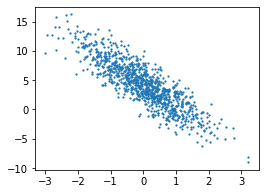

In [7]:
fig, axes = plt.subplots(1,1,figsize=(4,3))
axes.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(),s=1.5)

### Reading the data via torch API

In [8]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Generate a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [9]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [10]:
next(iter(data_iter))

[tensor([[ 0.2524,  0.3289],
         [ 0.3683, -0.4182],
         [-0.3802,  0.3866],
         [-0.5018, -1.0228],
         [-0.8683,  0.6951],
         [ 0.9989, -1.4452],
         [-0.8260, -0.2781],
         [ 0.7176,  0.4411],
         [ 0.5769, -0.8247],
         [ 1.3738,  1.1151]]),
 tensor([[ 3.5885],
         [ 6.3644],
         [ 2.1239],
         [ 6.6777],
         [ 0.0946],
         [11.1080],
         [ 3.5027],
         [ 4.1402],
         [ 8.1596],
         [ 3.1469]])]

## Define a model

### Function for initialize weight function

In [11]:
def getParams(inputSize,numHiddens):
    w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return (w,b)

### Linear Net Model

In [12]:
class LinearNet(StandardSNN):
    '''a standard net with linear regression'''
    def __init__(self,getParams,inputSize,numHiddens):
        self.params=getParams(inputSize,numHiddens)

    def __call__(self,X:torch.Tensor):
        return self.call_with_weight(X,self.params)

    def call_with_weight(self,X:torch.Tensor,weight:tuple):
        w,b=weight
        return torch.matmul(X,w)+b

In [13]:
net=LinearNet(getParams,2,1)
print(net.params)
rawParams=()
for param in net.params:
    rawParams+=(param.clone().detach().requires_grad_(True),)
print(rawParams)

(tensor([[-0.0086],
        [ 0.0084]], requires_grad=True), tensor([0.], requires_grad=True))
(tensor([[-0.0086],
        [ 0.0084]], requires_grad=True), tensor([0.], requires_grad=True))


### Set epochs

In [14]:
num_epochs=5

### Loss function

In [15]:
lossFunc=GradFreeMSELoss(net,reduction='none')

### MCS optimizer

In [16]:
mcs=MCSOptimizer(net.params,lossFunc,data_iter,\
                    maxLevyStepSize=0.3,\
                    nestNum=6)

In [17]:
l_epochs_mcs=[float(lossFunc(net(features), labels).mean())]
print(f'epoch 0, loss {l_epochs_mcs[0]:f}')
for epoch in range(num_epochs):
    mcs.step()
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        l_epochs_mcs.append(float(train_l.mean()))
        print(f'epoch {epoch + 1}, loss {l_epochs_mcs[epoch+1]:f}')

epoch 0, loss 34.341888
epoch 1, loss 0.010626
epoch 2, loss 0.000134
epoch 3, loss 0.000134
epoch 4, loss 0.000134
epoch 5, loss 0.000134


In [18]:
w,b=net.params
print(w,b)
print(f'loss of w: {true_w - w.reshape(true_w.shape)}')
print(f'loss of b: {true_b - b}')

tensor([[ 1.9958],
        [-3.4039]], requires_grad=True) tensor([4.1993], requires_grad=True)
loss of w: tensor([0.0042, 0.0039], grad_fn=<SubBackward0>)
loss of b: tensor([0.0007], grad_fn=<RsubBackward1>)


### Standard sgd

In [19]:
net.params=rawParams
print(net.params)

(tensor([[-0.0086],
        [ 0.0084]], requires_grad=True), tensor([0.], requires_grad=True))


In [20]:
def squared_loss(y_hat, y):  #@save
    """L2 loss"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [21]:
def sgd(params, lr, batch_size):  
    """sgd"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [22]:
lr = 0.03
loss = squared_loss

In [23]:
l_epochs_sgd=[]
l_epochs_sgd=[float(lossFunc(net(features), labels).mean())]
print(f'epoch 0, loss {l_epochs_sgd[0]:f}')
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = lossFunc(net(X), y)
        l.sum().backward()
        sgd(net.params, lr, batch_size) 
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        l_epochs_sgd.append(float(train_l.mean()))
        print(f'epoch {epoch + 1}, loss {l_epochs_sgd[epoch+1]:f}')

epoch 0, loss 34.341888
epoch 1, loss 0.000179
epoch 2, loss 0.000106
epoch 3, loss 0.000106
epoch 4, loss 0.000106
epoch 5, loss 0.000106


In [24]:
w,b=net.params
print(w,b)
print(f'loss of w: {true_w - w.reshape(true_w.shape)}')
print(f'loss of b: {true_b - b}')

tensor([[ 2.0004],
        [-3.4009]], requires_grad=True) tensor([4.2001], requires_grad=True)
loss of w: tensor([-0.0004,  0.0009], grad_fn=<SubBackward0>)
loss of b: tensor([-8.2016e-05], grad_fn=<RsubBackward1>)


## Visualize the Result

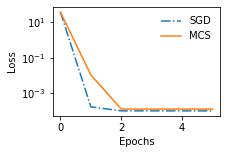

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(3,2))

axes.semilogy(range(0,num_epochs+1),l_epochs_sgd,linestyle='-.',label='SGD')
axes.semilogy(range(0,num_epochs+1),l_epochs_mcs,linestyle='-',label='MCS')


axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')

axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))

axes.legend(loc=0,frameon=False);